# Laborator 5

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pyod.models.pca import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from pyod.models.kpca import KPCA
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import layers, Model, Sequential

## Ex. 1.1

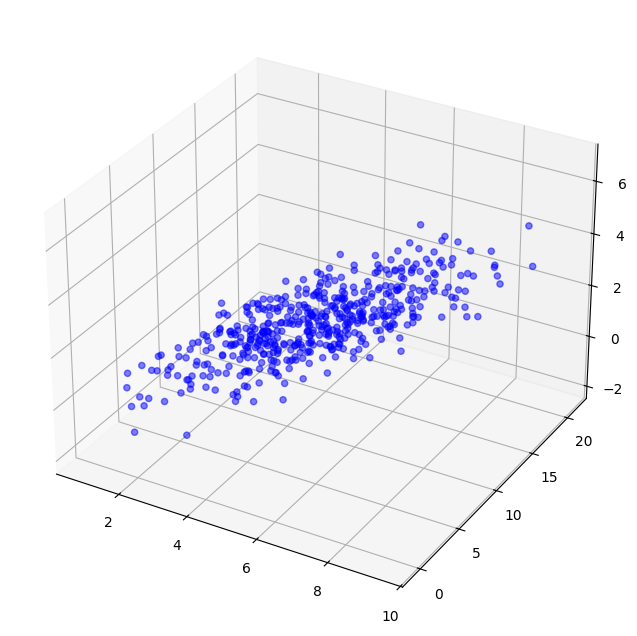

In [3]:
mean = np.array([5, 10, 2])
cov = np.array([[3,  2,  2],
                [2, 10,  1],
                [2,  1,  2]])

X = np.random.multivariate_normal(mean, cov, size=500)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c='b', marker='o', s=20, alpha=0.5)
plt.show()

X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

C = np.cov(X_centered, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(C)

idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

## Ex. 1.2

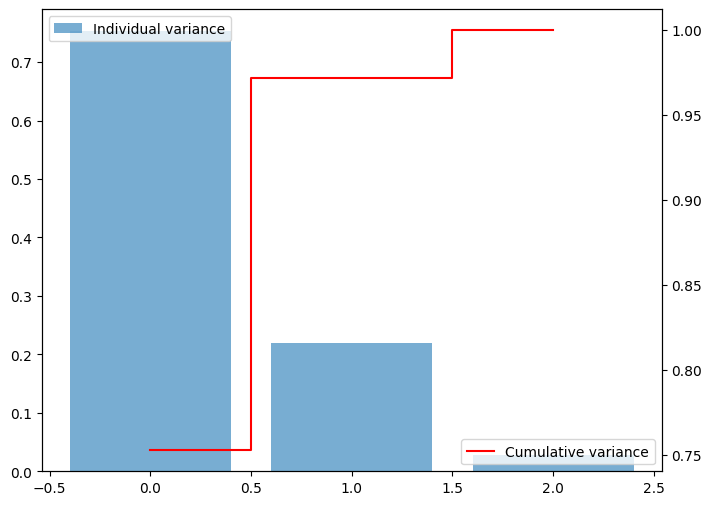

In [6]:
explained_var = eigenvalues / np.sum(eigenvalues)
cumulative_explained_var = np.cumsum(explained_var)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(np.arange(len(eigenvalues)), explained_var, alpha=0.6, label='Individual variance')

ax2 = ax.twinx()
ax2.step(np.arange(len(eigenvalues)), cumulative_explained_var, where='mid', color='red', label='Cumulative variance')

ax.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.show()

## Ex. 1.3

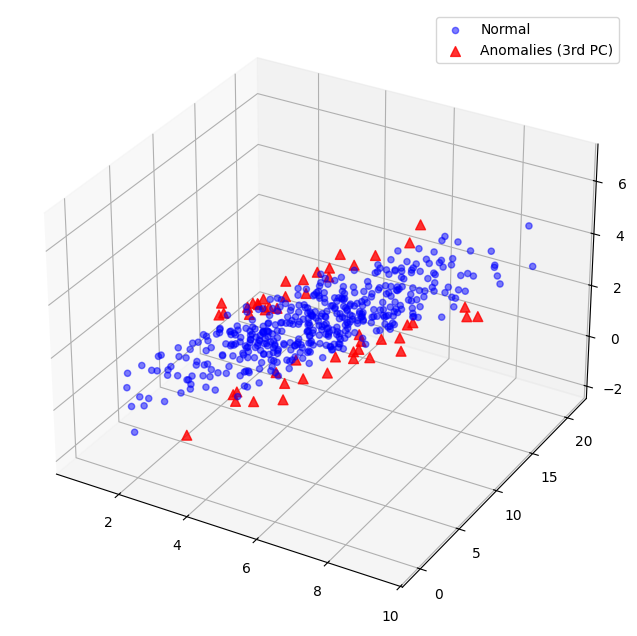

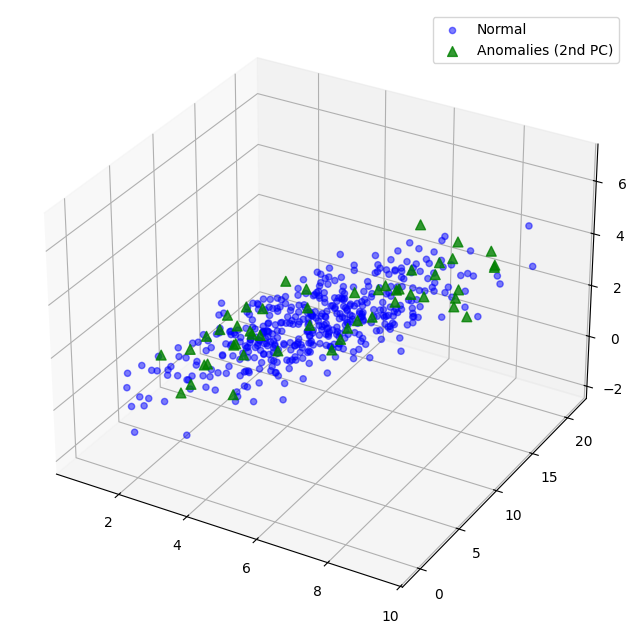

In [9]:
X_pca = X_centered @ eigenvectors

contamination_rate = 0.1
comp_index = 2
values_comp3 = X_pca[:, comp_index]

mean_comp3 = np.mean(values_comp3)
abs_deviation = np.abs(values_comp3 - mean_comp3)
threshold = np.quantile(abs_deviation, 1 - contamination_rate)

labels_comp3 = (abs_deviation > threshold).astype(int)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
normal_points = (labels_comp3 == 0)
anomalies = (labels_comp3 == 1)
ax.scatter(X[normal_points,0], X[normal_points,1], X[normal_points,2], c='b', marker='o', s=20, alpha=0.5, label='Normal')
ax.scatter(X[anomalies,0], X[anomalies,1], X[anomalies,2], c='r', marker='^', s=50, alpha=0.8, label='Anomalies (3rd PC)')
ax.legend()
plt.show()

comp_index = 1
values_comp2 = X_pca[:, comp_index]
mean_comp2 = np.mean(values_comp2)
abs_deviation2 = np.abs(values_comp2 - mean_comp2)
threshold2 = np.quantile(abs_deviation2, 1 - contamination_rate)
labels_comp2 = (abs_deviation2 > threshold2).astype(int)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
normal_points_2 = (labels_comp2 == 0)
anomalies_2 = (labels_comp2 == 1)
ax.scatter(X[normal_points_2,0], X[normal_points_2,1], X[normal_points_2,2], c='b', marker='o', s=20, alpha=0.5, label='Normal')
ax.scatter(X[anomalies_2,0], X[anomalies_2,1], X[anomalies_2,2], c='g', marker='^', s=50, alpha=0.8, label='Anomalies (2nd PC)')
ax.legend()
plt.show()

## Ex. 1.4

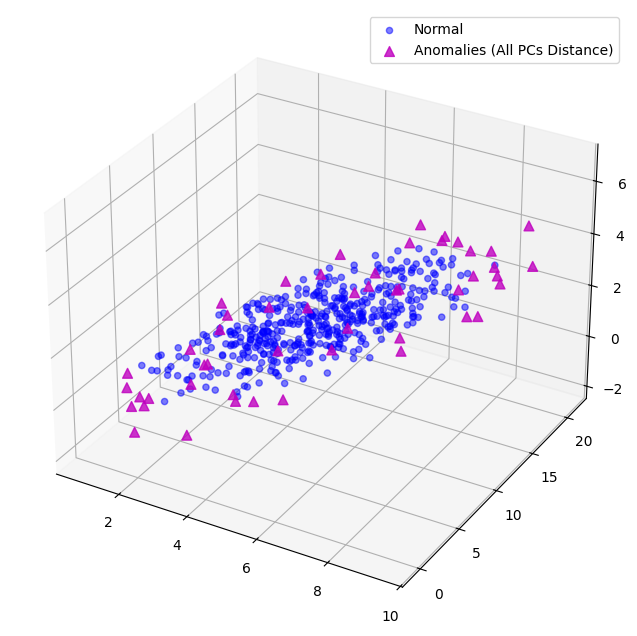

In [11]:
centroid_pca = np.mean(X_pca, axis=0)
std_pca = np.std(X_pca, axis=0)

std_pca[std_pca == 0] = 1e-9

normalized_distances = np.sqrt(np.sum(((X_pca - centroid_pca) / std_pca)**2, axis=1))

threshold_dist = np.quantile(normalized_distances, 1 - contamination_rate)
labels_dist = (normalized_distances > threshold_dist).astype(int)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
normal_points_dist = (labels_dist == 0)
anomalies_dist = (labels_dist == 1)
ax.scatter(X[normal_points_dist,0], X[normal_points_dist,1], X[normal_points_dist,2], c='b', marker='o', s=20, alpha=0.5, label='Normal')
ax.scatter(X[anomalies_dist,0], X[anomalies_dist,1], X[anomalies_dist,2], c='m', marker='^', s=50, alpha=0.8, label='Anomalies (All PCs Distance)')
ax.legend()
plt.show()

## Ex. 2.1

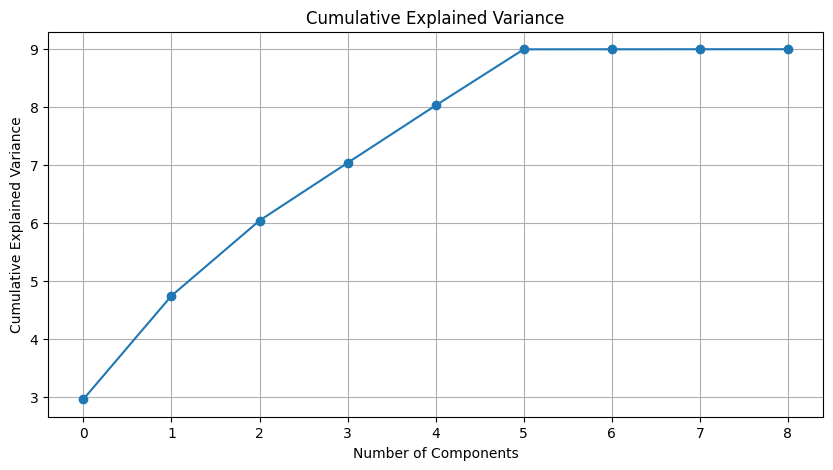

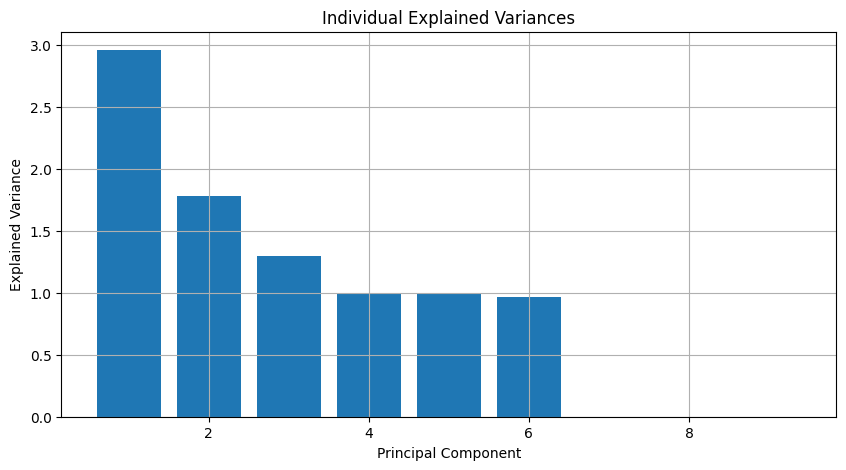

In [3]:
data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y)

contamination_rate = np.sum(y_train == 1) / len(y_train)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = PCA(contamination=contamination_rate)
clf.fit(X_train_norm)

explained_variance = clf.explained_variance_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.title('Individual Explained Variances')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

## Ex. 2.2

In [5]:
y_train_pred_pca = clf.predict(X_train_norm)
y_test_pred_pca = clf.predict(X_test_norm)

train_bal_acc_pca = balanced_accuracy_score(y_train, y_train_pred_pca)
test_bal_acc_pca = balanced_accuracy_score(y_test, y_test_pred_pca)

print("PCA Balanced Accuracy on Training Set:", train_bal_acc_pca)
print("PCA Balanced Accuracy on Test Set:", test_bal_acc_pca)

# clf_kpca = KPCA(contamination=contamination_rate)
# clf_kpca.fit(X_train_norm)

# y_train_pred_kpca = clf_kpca.predict(X_train_norm)

# y_test_pred_kpca = clf_kpca.predict(X_test_norm)

# train_bal_acc_kpca = balanced_accuracy_score(y_train, y_train_pred_kpca)
# test_bal_acc_kpca = balanced_accuracy_score(y_test, y_test_pred_kpca)

# print("KPCA Balanced Accuracy on Training Set:", train_bal_acc_kpca)
# print("KPCA Balanced Accuracy on Test Set:", test_bal_acc_kpca)

PCA Balanced Accuracy on Training Set: 0.9746970759653066
PCA Balanced Accuracy on Test Set: 0.9726041073449903


## Ex. 3.1

In [9]:
data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()

contamination_rate = np.mean(y == -1)
print("Contamination rate:", contamination_rate)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Contamination rate: 0.0


## Ex. 3.2

In [20]:
class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            layers.Dense(8, activation='relu', input_shape=(input_dim,)),
            layers.Dense(5, activation='relu'),
            layers.Dense(3, activation='relu')
        ])
        
        self.decoder = Sequential([
            layers.Dense(5, activation='relu', input_shape=(3,)),
            layers.Dense(8, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train_scaled.shape[1]
autoencoder = Autoencoder(input_dim)

C:\Users\Radu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Ex. 3.3

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208 - val_loss: 0.0185
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0152
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0119
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

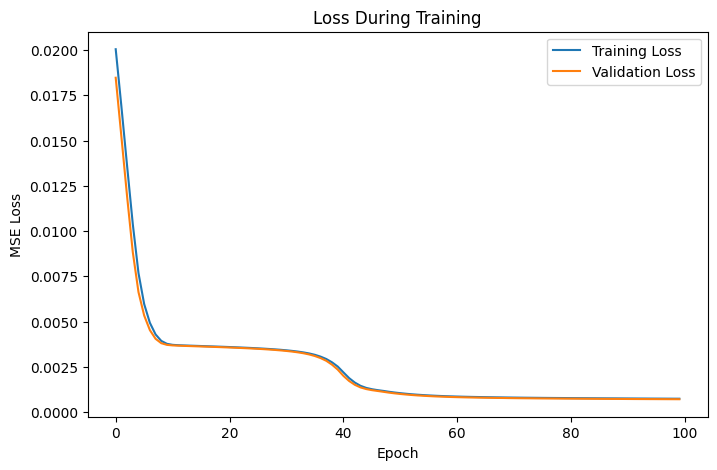

In [21]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=1024,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled)
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

## Ex. 3.4

In [22]:
X_train_reconstructed = autoencoder.predict(X_train_scaled)
train_errors = np.mean(np.square(X_train_scaled - X_train_reconstructed), axis=1)

threshold = np.quantile(train_errors, 1 - contamination_rate)

y_train_pred = (train_errors > threshold).astype(int)
y_train_pred = np.where(y_train_pred == 1, -1, 1)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
print("Training Balanced Accuracy:", train_balanced_acc)

X_test_reconstructed = autoencoder.predict(X_test_scaled)
test_errors = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)

y_test_pred = (test_errors > threshold).astype(int)
y_test_pred = np.where(y_test_pred == 1, -1, 1)

test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
print("Testing Balanced Accuracy:", test_balanced_acc)

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
Training Balanced Accuracy: 0.5
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
Testing Balanced Accuracy: 0.5


## Ex. 4.1

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)   

noise_factor = 0.35
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_test_noisy = tf.clip_by_value(x_test_noisy, 0.0, 1.0)
x_test_noisy = x_test_noisy.numpy()

## Ex. 4.2

In [25]:
class ConvAutoencoder(tf.keras.Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(8, (3,3), strides=2, activation='relu', padding='same'),
            layers.Conv2D(4, (3,3), strides=2, activation='relu', padding='same'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(4, (3,3), strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(8, (3,3), strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

cae = ConvAutoencoder()


## Ex. 4.3

In [26]:
cae.compile(optimizer='adam', loss='mse')

history = cae.fit(
    x_train, x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, x_test)
)

reconstructions_train = cae.predict(x_train)
train_errors = np.mean(np.square(x_train - reconstructions_train), axis=(1,2,3))

threshold = np.mean(train_errors) + np.std(train_errors)

def predict_anomalies(x_data):
    reconstructions = cae.predict(x_data)
    errors = np.mean(np.square(x_data - reconstructions), axis=(1,2,3))
    preds = (errors < threshold).astype(int)
    return preds, errors

test_preds, test_errors = predict_anomalies(x_test)
test_accuracy = np.mean(test_preds == 1)

noisy_preds, noisy_errors = predict_anomalies(x_test_noisy)
noisy_accuracy = np.mean(noisy_preds == 0)

print("Threshold:", threshold)
print("Accuracy on original test images:", test_accuracy)
print("Accuracy on noisy test images:", noisy_accuracy)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0709 - val_loss: 0.0055
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0021 - val_loss: 0.0020
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold: 0.0

## Ex. 4.4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


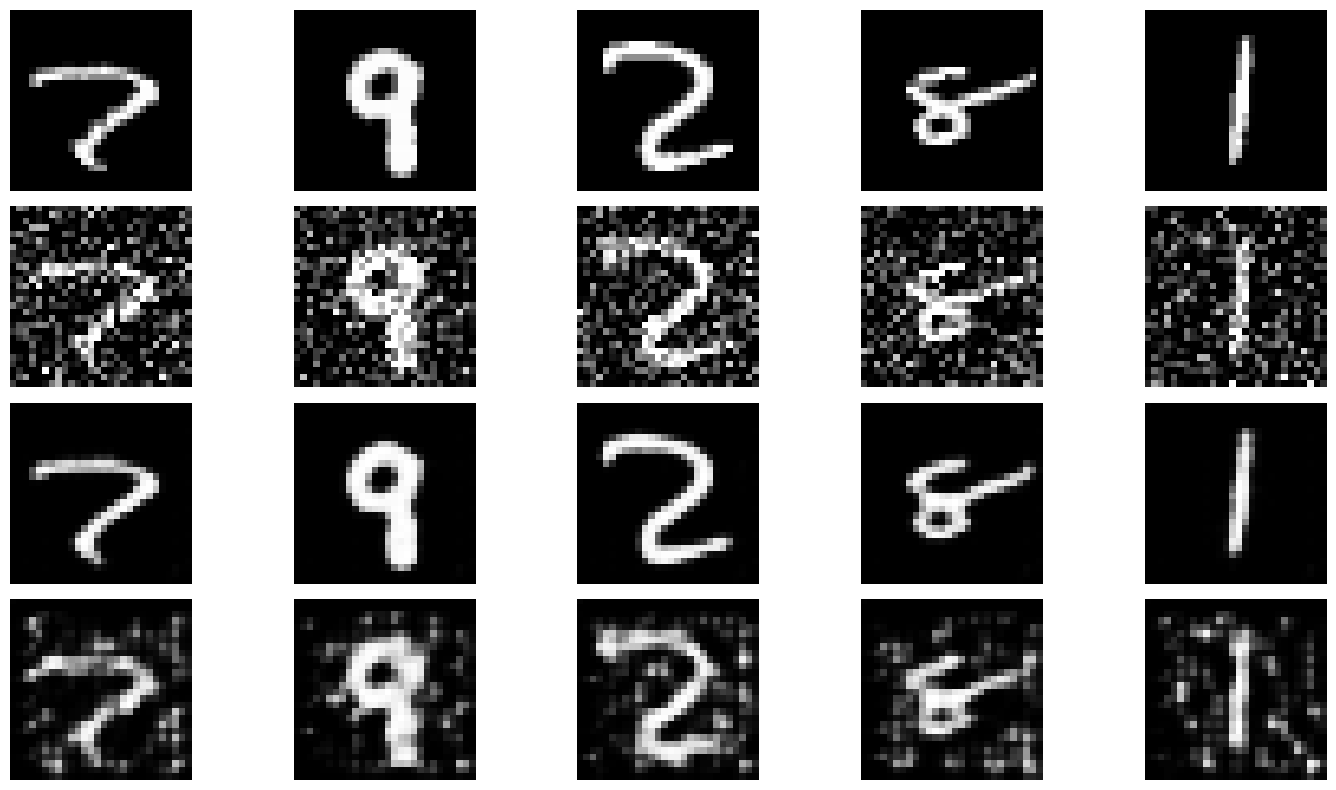

In [27]:
num_images = 5
indices = np.random.choice(len(x_test), num_images, replace=False)

reconstructions_test = cae.predict(x_test[indices])
reconstructions_noisy = cae.predict(x_test_noisy[indices])

plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(4, num_images, i+1)
    plt.imshow(x_test[indices[i]].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original", fontsize=14)
        
    plt.subplot(4, num_images, i+1+num_images)
    plt.imshow(x_test_noisy[indices[i]].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Noisy", fontsize=14)
        
    plt.subplot(4, num_images, i+1+2*num_images)
    plt.imshow(reconstructions_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Reconstructed\nfrom Original", fontsize=14)
        
    plt.subplot(4, num_images, i+1+3*num_images)
    plt.imshow(reconstructions_noisy[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Reconstructed\nfrom Noisy", fontsize=14)

plt.tight_layout()
plt.show()


## Ex. 4.5

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0821 - val_loss: 0.0108
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0087 - val_loss: 0.0086
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


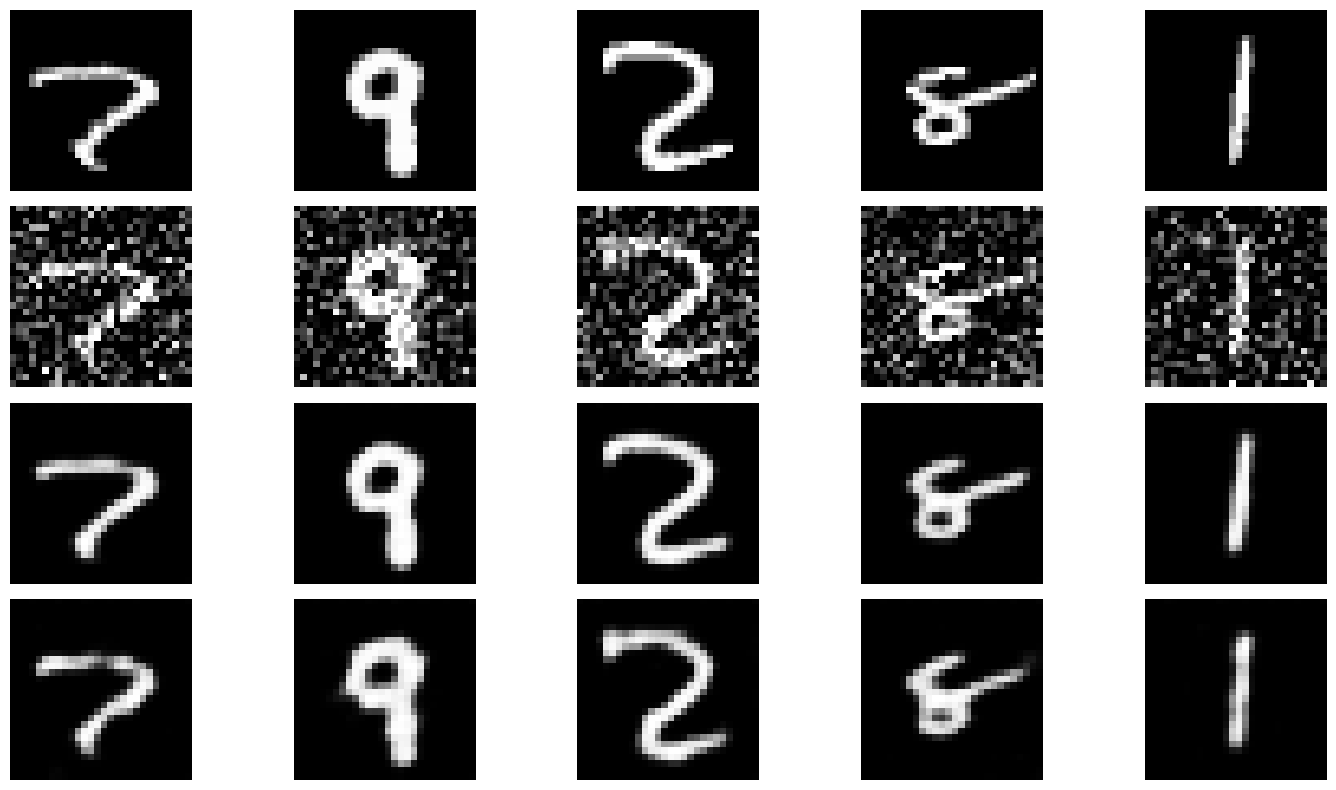

In [28]:
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, 0.0, 1.0)
x_train_noisy = x_train_noisy.numpy()

cae_denoise = ConvAutoencoder()
cae_denoise.compile(optimizer='adam', loss='mse')

cae_denoise.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

reconstructions_test_denoise = cae_denoise.predict(x_test[indices])
reconstructions_noisy_denoise = cae_denoise.predict(x_test_noisy[indices])

plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(4, num_images, i+1)
    plt.imshow(x_test[indices[i]].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original", fontsize=14)
        
    plt.subplot(4, num_images, i+1+num_images)
    plt.imshow(x_test_noisy[indices[i]].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Noisy", fontsize=14)
        
    plt.subplot(4, num_images, i+1+2*num_images)
    plt.imshow(reconstructions_test_denoise[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Denoised\nfrom Original", fontsize=14)
        
    plt.subplot(4, num_images, i+1+3*num_images)
    plt.imshow(reconstructions_noisy_denoise[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Denoised\nfrom Noisy", fontsize=14)

plt.tight_layout()
plt.show()
